In [1]:
import numpy as np                # library for mathematical operations with arrays
import pandas as pd               # library for data frames; includes useful functions for date arithmetic
import xarray as xr               # library for arrays, especially tailored to weather data
import matplotlib.pyplot as plt   # library for basic plotting

from plotting import plot_fields                    # function for visualizing spatial data in a map
from miscellaneous import get_nearest_grid_index    # helper function to find the grid indices for a selected location
from miscellaneous import find_onset_day            # function to identify the onset day based on time series of threshold exceedances
from miscellaneous import mark_wet_spells           # helper function to mark wet spells within a rainfall time series
from miscellaneous import mark_dry_spells           # helper function to mark 7-day dry spells within a rainfall time series
from miscellaneous import interpolate_forecasts     # function for bilinear interpolation of forecasts

In [2]:
fcst_dir = '/home/michael/bigdisk2/pro/SFE/Systems_daily_nc/'
#fcst_dir = '/home/ghacof/COF65/gcm/'
data_dir = '/home/michael/data/CONFER/RainOnset/QM-CHIRPS/'

We set a few parameters that are fixed for this exercise but can vary in general:

In [3]:
season = 'ond'          # season for which rainy season onset is considered
month_start = 8         # month in which we start the onset date search for this season
day_start = 15          # day within this month when the onset date search starts
nwks = 22               # length (number of weeks) of the onset search window

ndts = 7*nwks+23        # number of lead time days needed to calculate an onset date within the chosen search window

Let's load some daily CHIRPS data so we can experiment with the onset identification:

In [4]:
filename_chirps = f'{data_dir}chirps_example_{season}_2017-2022.nc'

data_load = xr.open_dataset(filename_chirps, engine='netcdf4')
lon_chirps = data_load.longitude.values
lat_chirps = data_load.latitude.values
prcp_chirps_daily = data_load.precipitation.values
data_load.close()

We need 1-day and 3-day accumulations during the time period specified above:

In [5]:
prcp_chirps_1d = prcp_chirps_daily[:,:ndts,:,:]
prcp_chirps_3d = prcp_chirps_daily[:,:ndts,:,:] + prcp_chirps_daily[:,1:(ndts+1),:,:] + prcp_chirps_daily[:,2:(ndts+2),:,:]

As for the bias-correction script, you can choose your favorite location within GHA. Since we only prepared OND data, your location should have an expected rainy season onset in OND though for the example to be meaningful. You can also choose a year between 2017 and 2022.

Text(0.5, 1.0, 'Daily CHIRPS rainfall amounts at Nairobi in OND 2020')

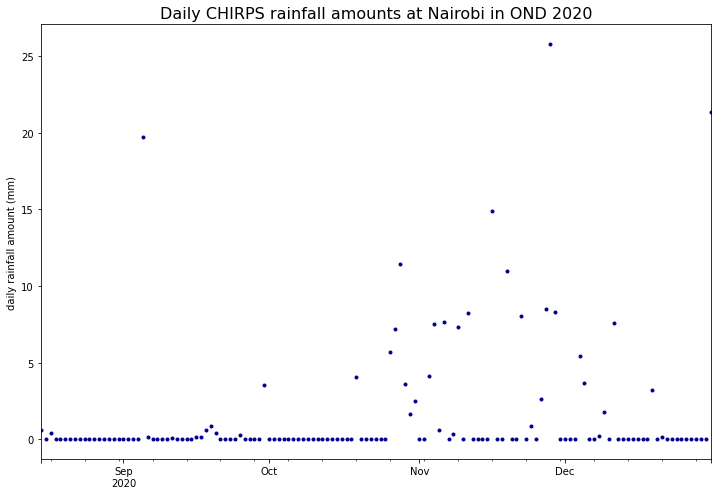

In [16]:
lon_exmpl = 36.82       # longitude of example location
lat_exmpl = -1.29       # latitude of example location
name_exmpl = 'Nairobi'  # name of the selected location
year_exmpl = 2020

ix, iy = get_nearest_grid_index(lon_exmpl, lat_exmpl, lon_chirps, lat_chirps)

iyr = {2017:0, 2018:1, 2019:2, 2020:3, 2021:4, 2022:5}[year_exmpl]

date_start = f'{year_exmpl}-{month_start}-{day_start}'

precp_series = pd.Series(prcp_chirps_1d[iyr,:,iy,ix], index=pd.date_range(start=date_start, periods=ndts))

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12,8))
precp_series[:f'{year_exmpl}-12-31'].plot(style='.', color='darkblue', ax=ax)
ax.set_ylabel('daily rainfall amount (mm)')
ax.set_title(f'Daily CHIRPS rainfall amounts at {name_exmpl} in OND {year_exmpl}', fontsize=16)

Now, we set some key parameters of the rainy season onset definition:

In [17]:
thr_wet = 20.      # the rainfall amount within 3 days required to consider these days a 'wet spell'
thr_dry = 1.       # the daily rainfall amount below which the day will be considered a 'dry day'

We highlight the corresponding 'wet spells' and 'dry spells' of at least 7 days duration, and calculate the date identified as the rainy season onset according to these criteria. Try a few different values to see how it affects the onset date.

Text(0.5, 1.0, 'OND 2020 onset date for Nairobi')

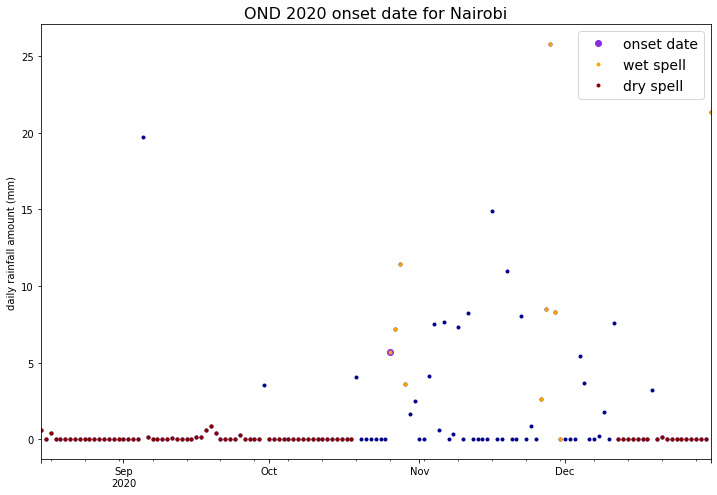

In [20]:
exc1_ind = np.greater(prcp_chirps_1d[iyr,:,iy,ix], thr_dry)     # days with more than {thr_dry}mm rainfall
exc20_ind = np.greater(prcp_chirps_3d[iyr,:,iy,ix], thr_wet)    # 3-day periods with more than {thr_wet}mm rainfall

onset_day = find_onset_day(exc1_ind, exc20_ind)

precp_series_wet = precp_series.where(mark_wet_spells(exc1_ind, exc20_ind),np.nan)
precp_series_dry = precp_series.where(mark_dry_spells(exc1_ind),np.nan)
precp_series_onset = precp_series.where(np.arange(1,ndts+1)==onset_day,np.nan)

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12,8))
precp_series[:f'{year_exmpl}-12-31'].plot(style='.', color='darkblue', ax=ax)
precp_series_onset[:f'{year_exmpl}-12-31'].plot(style='o', color='blueviolet', label='onset date', ax=ax)
precp_series_wet[:f'{year_exmpl}-12-31'].plot(style='.', color='orange', label='wet spell', ax=ax)
precp_series_dry[:f'{year_exmpl}-12-31'].plot(style='.', color='darkred', label='dry spell', ax=ax)
ax.legend(fontsize=14)
ax.set_ylabel('daily rainfall amount (mm)')
ax.set_title(f'OND {year_exmpl} onset date for {name_exmpl}', fontsize=16)

Now, let's load a real forecast and derive an ensemble of onset dates from it. The following parameters are fixed for this exercise but can be changed in general:

In [22]:
year_fcst = 2023        # year for which the bias-corrected forecasts should be generated

lon_bounds = [20, 53]   # longitude range of the domain of interest
lat_bounds = [-15, 23]  # latitude range of the domain of interest

system = 'ecmwf'        # forecast system on which the rainy season onset forecasts will be based

In [23]:
filename_fcst = f'{fcst_dir}total_precipitation_{system}_51_{year_fcst}_{month_start}.nc4'

data_load = xr.open_dataset(filename_fcst, engine='netcdf4')
data_subset = data_load.sel(g0_lat_2=slice(lat_bounds[1],lat_bounds[0]), g0_lon_3=slice(lon_bounds[0],lon_bounds[1]))
lon_fcst = data_subset.g0_lon_3.values
lat_fcst = data_subset.g0_lat_2.values[::-1]
#lead_time_fcst = data_subset.forecast_time1.values/3600e9)
prcp_fcst = data_subset.TP_GDS0_SFC.values[:,:,::-1,:]
data_load.close()

nmbs, nlts, nlatf, nlonf = prcp_fcst.shape

We calculate daily and 3-day rainfall amounts from cumulative precipitation amounts given in the raw forecast file, and as for the bias-correction exercise we interpolate to the target grid:

In [24]:
# Calculate forecasts of daily and 3-day precipitation accumulations and convert to mm/m^2
istrt = day_start-1
prcp_fcst_1d = 1000*(prcp_fcst[:,istrt:(istrt+ndts),:,:]-prcp_fcst[:,(istrt-1):(istrt+ndts-1),:,:])
prcp_fcst_3d = 1000*(prcp_fcst[:,(istrt+2):(istrt+ndts+2),:,:]-prcp_fcst[:,(istrt-1):(istrt+ndts-1),:,:])

prcp_fcst_1d_itp = interpolate_forecasts(prcp_fcst_1d, lat_fcst, lon_fcst, lat_chirps, lon_chirps)
prcp_fcst_3d_itp = interpolate_forecasts(prcp_fcst_3d, lat_fcst, lon_fcst, lat_chirps, lon_chirps)

Let's plot some of the interpolated, daily precipitation forecasts:

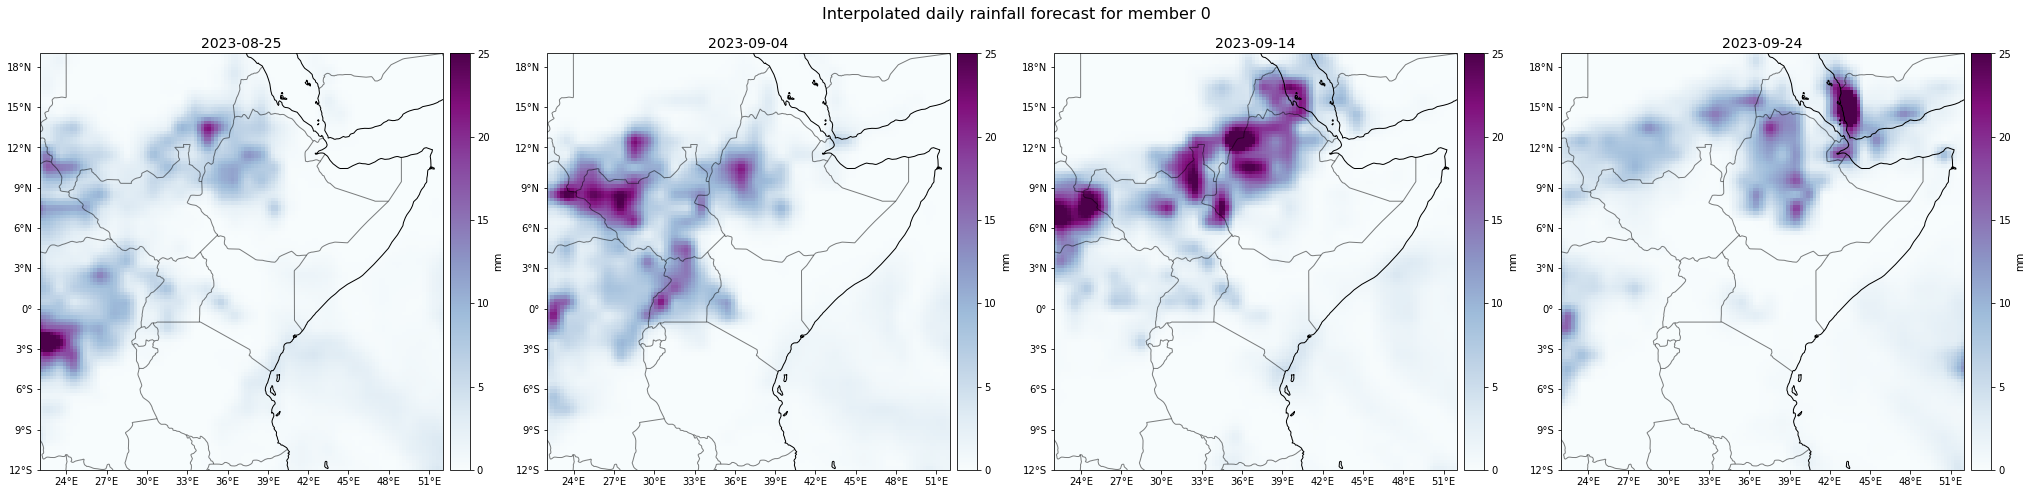

In [27]:
imb = 0                           # ensemble member
lead_selection = [10,20,30,40]    # forecast lead times (days after the forecast initialization date)

plot_fields (fields_list = [prcp_fcst_1d_itp[imb,ilt,:,:] for ilt in lead_selection],
          lon = lon_chirps,
          lat = lat_chirps,
          lon_bounds = [22, 52],
          lat_bounds = [-12, 19],
          main_title = f'Interpolated daily rainfall forecast for member {imb}',
          subtitle_list = [(pd.Timestamp(f'{year_fcst}-{month_start}-{day_start}')+pd.Timedelta(days=i)).strftime("%Y-%m-%d") for i in lead_selection],
          vmin = 0,
          vmax = 25,
          unit = 'mm')

We have seen that these forecasts often have systematic biases, but here, instead of bias-correcting the forecasts, we adjust the thresholds of the onset definition such that the forecasts exceed {thr_dry}mm per day and {thr_wet}mm in 3 days with the same climatological frequency as the CHIRPS data.

For the choices thr_dry=1mm and thr_wet=20mm, we have pre-calculated these adjusted thresholds and can load them from disk: